# Create a function that calculates the spectrogram using a Hamming window and using numpy fft and half a window overlap between two time steps in the spectrogram.

In [1]:
import pandas as pd
import soundfile as sf
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
from scipy.signal import butter, lfilter, freqz,firwin,kaiserord,filtfilt,decimate
from numpy.lib import stride_tricks
from scipy.io import wavfile

In [2]:
##### reading the sound files from the down_loaded_freesound_files3.csv
#same as the code used in task a and b

sfile = pd.read_csv('down_loaded_freesound_files3.csv') 

S_one = (sfile.newfilename[17])

S_two = (sfile.newfilename[0])

S_three = (sfile.newfilename[21])

S_four = (sfile.newfilename[1])

print(S_one)
print(S_two)
print(S_three)
print(S_four)

119860.wav
55093.wav
179008.wav
55099.wav


In [11]:
array1, sampfreq1 = sf.read(S_one)
array2, sampfreq2 = sf.read(S_two)
array3, sampfreq3 = sf.read(S_three)
array4, sampfreq4 = sf.read(S_four)

WAV file:  Fs = 44100, x.shape = (543782,), x.dtype = float64


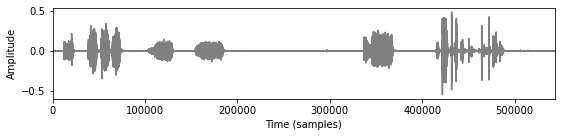

WAV file:  Fs = 44100, x.shape = (1317865,), x.dtype = float64


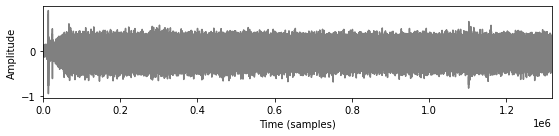

WAV file:  Fs = 44100, x.shape = (65536,), x.dtype = float64


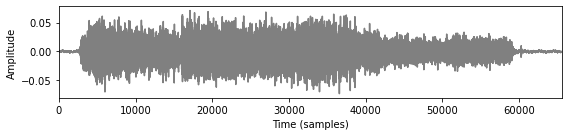

WAV file:  Fs = 44100, x.shape = (493931,), x.dtype = float64


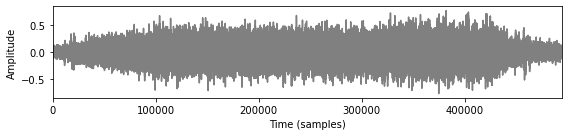

In [3]:
#same as the code used in task a and b
def print_plot_play(x, Fs, text=''):
# Prints information about an audio singal, plots the waveform, Creates player 
        # x: Input signal
       # # Fs: Sampling rate of x    
        #text: Text to print
        
    print('%s Fs = %d, x.shape = %s, x.dtype = %s' % (text, Fs, x.shape, x.dtype))
    plt.figure(figsize=(8, 2))
    plt.plot(x, color='gray')
    plt.xlim([0, x.shape[0]])
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()



#Load the audio files ans ample rates
x1, Fs1 = sf.read(S_one)
x2,Fs2  = sf.read(S_two)
x3,Fs3  = sf.read(S_three)
x4,Fs4  = sf.read(S_four)

#plotting waveforms
print_plot_play(x=x1, Fs=Fs1, text='WAV file: ' )
print_plot_play(x=x2, Fs=Fs2, text='WAV file: ')
print_plot_play(x=x3, Fs=Fs3, text='WAV file: ') 
print_plot_play(x=x4, Fs=Fs4, text='WAV file: ') 

#  Band-pass filter is a filter that passes frequencies within a range and rejects frequencies outside that range.
#

In [4]:
#https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html
#https://timsainburg.com/python-mel-compression-inversion.html
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def overlap(X, window_size, window_step):
    """
    Create an overlapped version of X
    Parameters
    ----------
    X : ndarray, shape=(n_samples,)
        Input signal to window and overlap
    window_size : int
        Size of windows to take
    window_step : int
        Step size between windows
    Returns
    -------
    X_strided : shape=(n_windows, window_size)
        2D array of overlapped X
    """
    if window_size % 2 != 0:
        raise ValueError("Window size must be even!")
    # Make sure there are an even number of windows before stridetricks
    append = np.zeros((window_size - len(X) % window_size))
    X = np.hstack((X, append))

    ws = window_size
    ss = window_step
    a = X

    valid = len(a) - ws
    nw = (valid) // ss
    out = np.ndarray((nw, ws), dtype=a.dtype)

    for i in np.arange(nw):
        # "slide" the window along the samples
        start = i * ss
        stop = start + ws
        out[i] = a[start:stop]

    return out

#https://timsainburg.com/python-mel-compression-inversion.html

def stft(
    X, fftsize=128, step=65, mean_normalize=True, real=False, compute_onesided=True
):
    """
    Compute STFT for 1D real valued input X
    """
    if real:
        local_fft = np.fft.rfft
        cut = -1
    else:
        local_fft = np.fft.fft
        cut = None
    if compute_onesided:
        cut = fftsize // 2
    if mean_normalize:
        X -= X.mean()

    X = overlap(X, fftsize, step)

    size = fftsize
    win = 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))
    X = X * win[None]
    X = local_fft(X)[:, :cut]
    return X


def spectrogram(d, log=True, thresh=5, fft_size=512, step_size=64):
    """
    creates a spectrogram
    log: take the log of the spectrgram
    thresh: threshold minimum power for log spectrogram
    """
    specgram = np.abs(
        stft(d, fftsize=fft_size, step=step_size, real=False, compute_onesided=True)
    )

    if log == True:
        specgram /= specgram.max()  # volume normalize to max 1
        specgram = np.log10(specgram)  # take log
        specgram[
            specgram < -thresh
        ] = -thresh  # set anything less than the threshold as the threshold
    else:
        specgram[
            specgram < thresh
        ] = thresh  # set anything less than the threshold as the threshold

    return specgram






In [5]:
#https://timsainburg.com/python-mel-compression-inversion.html#
fft_size = 2048  # window size for the FFT
step_size = fft_size // 16  # distance to slide along the window (in time)
spec_thresh = 4  # threshold for spectrograms (lower filters out more noise)
lowcut = 500  # Hz # Low cut for our butter bandpass filter
highcut = 15000  # Hz # High cut for our butter bandpass filter


In [12]:
#https://timsainburg.com/python-mel-compression-inversion.html
spec1 = spectrogram(array1,fft_size=fft_size,step_size=step_size,log=True,thresh=spec_thresh)
spec2 = spectrogram(array2,fft_size=fft_size,step_size=step_size,log=True,thresh=spec_thresh)
spec3 = spectrogram(array3,fft_size=fft_size,step_size=step_size,log=True,thresh=spec_thresh)
spec4 = spectrogram(array4,fft_size=fft_size,step_size=step_size,log=True,thresh=spec_thresh)

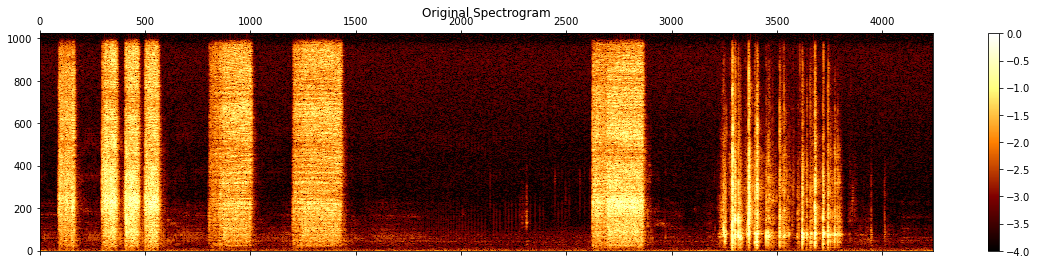

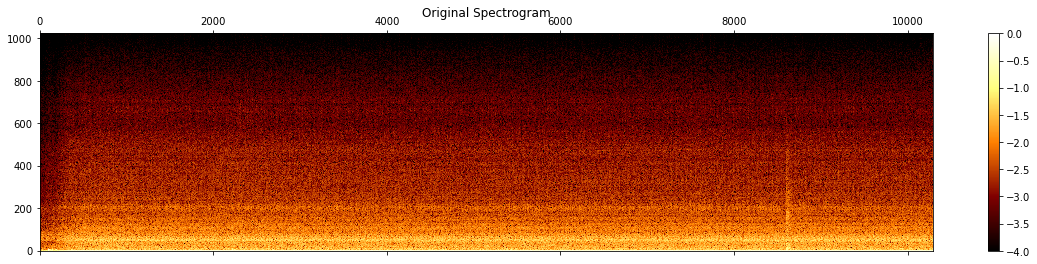

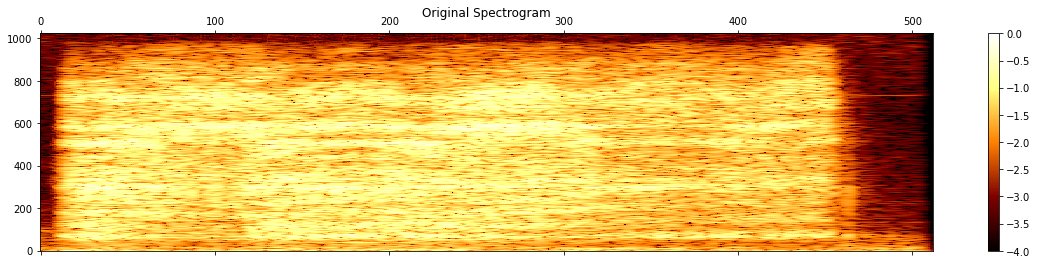

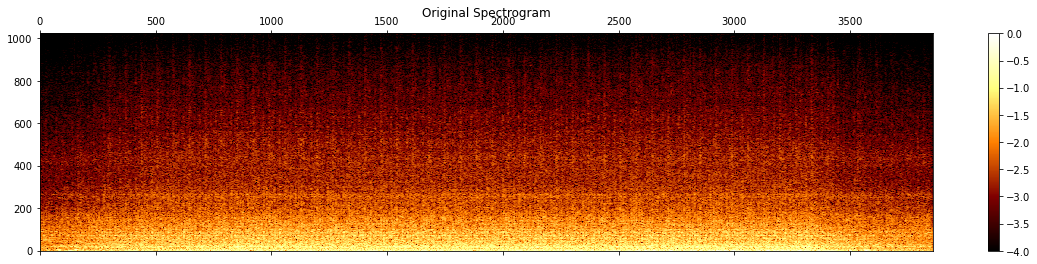

In [13]:
#https://timsainburg.com/python-mel-compression-inversion.html
for t in (spec1,spec2,spec3,spec4):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
    cax = ax.matshow(np.transpose(t),interpolation="nearest",aspect="auto",cmap=plt.cm.afmhot,origin="lower")
    fig.colorbar(cax)
    plt.title("Original Spectrogram")

# reference
#https://timsainburg.com/python-mel-compression-inversion.html
#https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html
#https://www.mathworks.com/help/signal/ref/spectrogram.html
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html